# High Performance Python

## Charged Particle Simulations

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def gen_particles(N):
    coords = np.ones((N, 2))
    r = np.arange(0, N)
    coords[:, 0] = 0.5 + 0.3*np.sin(2*np.pi*r/N + 0.1)
    coords[:, 1] = 0.5 + 0.3*np.cos(2*np.pi*r/N + 0.1)
    return coords


def plot_potential_grid(potential_grid):
    plt.imshow(potential_grid, origin="lower")
    plt.axis("off")

In [3]:
NUM_PARTICLES = 5
GRID_RESOLUTION = 200
PARTICLE_COORDS = gen_particles(NUM_PARTICLES)
CHARGES = np.random.choice(np.int32([-1, 1]), (NUM_PARTICLES, ))

benchmarks = {}

### Python Loops

In [4]:
def V_potential(grid_pos, particle_coords, k):
    """
    Determine potential at a given grid point by 
    summing the contribution from each particle
    """
    V = 0
    for j in range(len(particle_coords)):
        dist = np.linalg.norm(grid_pos - particle_coords[j])
        if dist > 0:
            V -= k[j]*np.log(dist)
        else:
            V -= k[j]*np.inf
    return V


def potential_py(particle_coords, grid_resolution, charges):
    potential_grid = np.zeros((grid_resolution, grid_resolution))
    for i in range(len(potential_grid)):
        for m in range(len(potential_grid[i])):
            grid_pos = np.asarray([i, m])/grid_resolution
            potential_grid[m,i] = V_potential(
                grid_pos, particle_coords, charges
            )
    return potential_grid

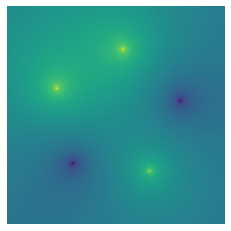

In [5]:
potential_grid_py = potential_py(
    PARTICLE_COORDS, GRID_RESOLUTION, CHARGES
)
plot_potential_grid(potential_grid_py);

In [6]:
benchmarks["py"] = %timeit -o potential_py(PARTICLE_COORDS, GRID_RESOLUTION, CHARGES)

3.35 s ± 278 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Numpy

In [7]:
def potential_np(particle_coords, grid_resolution, charges):
    # Create mesh xx, yy
    x = np.linspace(0, 1, grid_resolution)
    y = np.linspace(0, 1, grid_resolution)
    xx, yy = np.meshgrid(x, y)

    # Create matrix of zeros
    potential_grid = np.zeros((grid_resolution, grid_resolution))

    # Increment the matrix for each particle
    for i in range(len(particle_coords)):
        delta_x = np.square(xx - particle_coords[i, 0])
        delta_y = np.square(yy - particle_coords[i, 1])
        distance = np.sqrt(delta_x + delta_y)
        potential_grid += -charges[i]*np.log(distance)

    return potential_grid

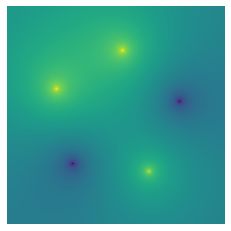

In [8]:
potential_grid_np = potential_np(
    PARTICLE_COORDS, GRID_RESOLUTION, CHARGES
)
plot_potential_grid(potential_grid_np)

In [9]:
benchmarks["np"] = %timeit -o potential_np(PARTICLE_COORDS, GRID_RESOLUTION, CHARGES)

4.07 ms ± 562 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Numba

In [10]:
from numba import jit

In [11]:
@jit(nopython=True)
def V_potential_numba(grid_pos, particle_coords, k):
    V = 0
    for j in range(len(particle_coords)):
        dist = np.sqrt(np.sum(np.square(grid_pos - particle_coords[j])))
        if dist > 0:
            V -= k[j]*np.log(dist)
        else:
            V -= k[j]*np.inf
    return V


@jit(nopython=True)
def potential_numba(particle_coords, grid_resolution, charges):
    potential_grid = np.zeros((grid_resolution, grid_resolution))
    for i in range(grid_resolution):
        for m in range(grid_resolution):
            grid_pos = np.asarray([i, m])/grid_resolution
            potential_grid[m,i] = V_potential_numba(grid_pos, 
                                                    particle_coords, 
                                                    charges)
    return potential_grid

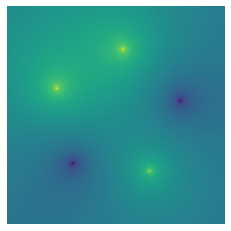

In [12]:
potential_grid_numba = potential_numba(
    PARTICLE_COORDS, GRID_RESOLUTION, CHARGES
)
plot_potential_grid(potential_grid_numba)

In [13]:
benchmarks["numba"] = %timeit -o potential_numba(PARTICLE_COORDS, GRID_RESOLUTION, CHARGES)

48.9 ms ± 4.43 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Cython

In [14]:
%load_ext Cython

In [15]:
%%cython
import numpy as np
cimport numpy as np
import math

DTYPE = np.float64

cpdef double V_potential_cython(
    double[:] grid_pos, double[:, :] particle_coords, int[:] k
):
    cdef double V = 0.0
    cdef double x_dist
    cdef double y_dist
    cdef double dist
    
    for j in range(len(particle_coords)):
        x_dist = grid_pos[0] - particle_coords[j][0]
        y_dist = grid_pos[1] - particle_coords[j][1]
        dist = math.sqrt(x_dist**2 + y_dist**2)
        if dist > 0:
            V -= k[j]*math.log(dist)
        else:
            V -= k[j]*math.inf
    return V


cpdef np.ndarray[double, ndim=2] potential_cython(
    double[:, :] particle_coords, 
    int grid_resolution, 
    int[:] charges
):
    cdef np.ndarray[double, ndim=2] potential_grid
    cdef np.ndarray[double, ndim=1] grid_pos
    
    grid_pos = np.zeros((2,), DTYPE)
    potential_grid = np.zeros((grid_resolution, grid_resolution))
    for i in range(grid_resolution):
        for m in range(grid_resolution):
            grid_pos[0] = i/grid_resolution
            grid_pos[1] = m/grid_resolution
            potential_grid[m, i] = V_potential_cython(
                grid_pos, particle_coords, charges
            )
    return potential_grid

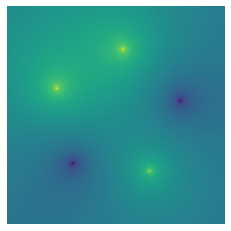

In [16]:
potential_grid_cython = potential_cython(
    PARTICLE_COORDS, GRID_RESOLUTION, CHARGES
)
plot_potential_grid(potential_grid_cython)

In [17]:
benchmarks["cython"] = %timeit -o potential_cython(PARTICLE_COORDS, GRID_RESOLUTION, CHARGES)

133 ms ± 3.62 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### C++ with pybind11

In [18]:
from pyhpc_cpp import calc_potential_grid


def potential_cpp(
    particle_coords, grid_resolution, charges, num_threads=1
):
    x_coords = particle_coords[:, 0]
    y_coords = particle_coords[:, 1]
    grid = calc_potential_grid(
        x_coords, y_coords, grid_resolution, charges, num_threads
    )
    return np.reshape(grid, (grid_resolution, grid_resolution))

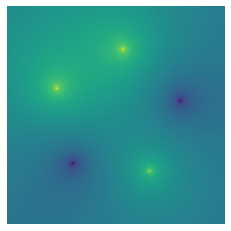

In [19]:
charges = CHARGES.astype('int32')

potential_grid_cpp = potential_cpp(
    PARTICLE_COORDS, GRID_RESOLUTION, charges
)
plot_potential_grid(potential_grid_cpp)

In [20]:
benchmarks["cpp"] = %timeit -o potential_cpp(PARTICLE_COORDS, GRID_RESOLUTION, charges)

3.66 ms ± 206 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### With multithreading using OpenMP

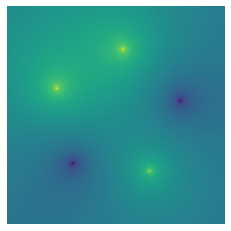

In [21]:
num_threads = 8

potential_grid_omp = potential_cpp(
    PARTICLE_COORDS, GRID_RESOLUTION, charges, num_threads)
plot_potential_grid(potential_grid_omp)

In [22]:
benchmarks["cpp-omp"] = %timeit -o potential_grid_omp = potential_cpp(PARTICLE_COORDS, GRID_RESOLUTION, charges, num_threads)

1.18 ms ± 138 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### PyOpenCL

In [23]:
open_cl_kernel = """
__kernel void potential_cl(
    __global const double *x_pos_buf,
    __global const double *y_pos_buf,
    __global const double *x_grid_buf,
    __global const double *y_grid_buf,
    __global const int *charges_buf,
    const long grid_resolution,
    const long num_particles,
    __global double *potential_grid_buf
) {{
    double x_step;
    double y_step;
    double dist;
    int index;

    long i = get_global_id(0);
    long j = get_global_id(1);

    for (int k = 0; k < num_particles; ++k) {{
        x_step = x_grid_buf[i] - x_pos_buf[k];
        y_step = y_grid_buf[j] - y_pos_buf[k];
        dist = sqrt(x_step*x_step + y_step*y_step);
        
        index = i + grid_resolution*j;
        potential_grid_buf[index] -= charges_buf[k]*log(dist);
    }}
}}
"""

In [25]:
import pyopencl as cl


# TODO: Update function to take input args
def potential_cl(context, queue, program):
    # Get our input arrays as correctly type numpy arrays
    x_pos = PARTICLE_COORDS[:, 0].astype("float64")
    y_pos = PARTICLE_COORDS[:, 1].astype("float64")
    x_grid = np.linspace(0, 1, GRID_RESOLUTION + 1, dtype="float64")
    y_grid = np.linspace(0, 1, GRID_RESOLUTION + 1, dtype="float64")
    charges = CHARGES.astype("int32")
    potential_grid_cl = np.zeros(GRID_RESOLUTION**2, dtype="float64")

    # Create the OpenCL memory buffers to pass to the kernerl
    mf = cl.mem_flags
    x_pos_buf = cl.Buffer(
        context, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=x_pos
    )
    y_pos_buf = cl.Buffer(
        context, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=y_pos
    )
    x_grid_buf = cl.Buffer(
        context, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=x_grid
    )
    y_grid_buf = cl.Buffer(
        context, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=y_grid
    )
    charges_buf = cl.Buffer(
        context, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=charges
    )
    potential_grid_buf = cl.Buffer(
        context, mf.WRITE_ONLY | mf.COPY_HOST_PTR, hostbuf=potential_grid_cl
    )
    grid_resolution = np.int64(GRID_RESOLUTION)
    num_particles = np.int64(NUM_PARTICLES)

    global_id_sizes = (GRID_RESOLUTION, GRID_RESOLUTION,)
    kernel_args = (
        x_pos_buf, 
        y_pos_buf, 
        x_grid_buf, 
        y_grid_buf, 
        charges_buf, 
        grid_resolution, 
        num_particles,
        potential_grid_buf
    )
    program.potential_cl(queue, global_id_sizes, None, *kernel_args)
    
    cl.enqueue_copy(queue, potential_grid_cl, potential_grid_buf)
    
    potential_grid_cl = potential_grid_cl.reshape(
        (grid_resolution, grid_resolution)
    )
    
    return potential_grid_cl

#### Using the CPU

C:\Users\hsaun\miniconda3\envs\hpc-test\lib\site-packages\pyopencl\__init__.py:269: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


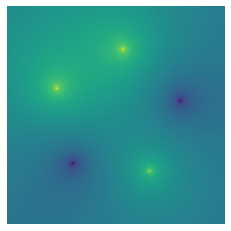

In [26]:
from cl_utils import get_device

# Create a context and compile the OpenCL kernel for CPU
cpu_device = get_device("CPU")
cpu_context = cl.Context([cpu_device])
cpu_queue = cl.CommandQueue(cpu_context)
cpu_program = cl.Program(cpu_context, open_cl_kernel).build()

potential_grid_cl_cpu = potential_cl(
    cpu_context, cpu_queue, cpu_program
)
plot_potential_grid(potential_grid_cl_cpu)

In [27]:
benchmarks["ocl-cpu"] = %timeit -o potential_cl(cpu_context, cpu_queue, cpu_program)

1.76 ms ± 138 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


#### Using the GPU

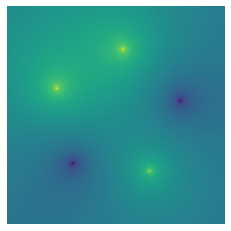

In [28]:
# Create a context and compile the OpenCL kernel for GPU
gpu_device = get_device("GPU", "Intel")
gpu_context = cl.Context([gpu_device])
gpu_queue = cl.CommandQueue(gpu_context)
gpu_program = cl.Program(gpu_context, open_cl_kernel).build()

potential_grid_cl_gpu = potential_cl(
    gpu_context, gpu_queue, gpu_program
)
plot_potential_grid(potential_grid_cl_gpu)

In [29]:
benchmarks["ocl-gpu"] = %timeit -o potential_cl(gpu_context, gpu_queue, gpu_program)

1.65 ms ± 128 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Benchmark Comparisons

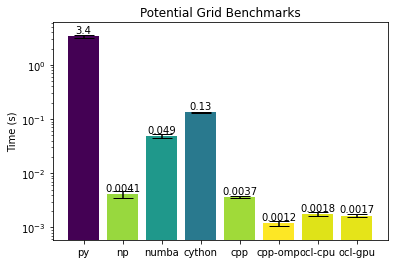

In [30]:
import plotting

funcs = []
times = []
stdevs = []
for func_name, result in benchmarks.items():
    funcs.append(func_name)
    times.append(result.average)
    stdevs.append(result.stdev)

plotting.plot_bar_chart(
    funcs, 
    times,
    yerr=stdevs,
    capsize=10,
    title="Potential Grid Benchmarks", 
    ylabel="Time (s)"
);